# Homework 4

**Due: 03/01/2018** (Thursday 1st March at 11:59pm).

## Instructions

+ In any case, develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**

## Readings

Before attempting the homework, it is probably a good idea to:
+ Read chapter 1, 2 of [Rasmussen](http://www.gaussianprocess.org/gpml/chapters/);
+ Review the slides of lectures 10, 11, & 12; and
+ Review the corresponding lecture handouts.

## Problem 1 - The Mauna Loa CO$_2$ data set

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start on March 1958 and go all the way to Janurary 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python script below, downloads and plots the data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import GPy
%matplotlib inline
from sklearn.linear_model import ARDRegression, LinearRegression
np.set_printoptions(suppress=True)
import scipy
import cPickle as pickle

Text(0,0.5,u'$y$')

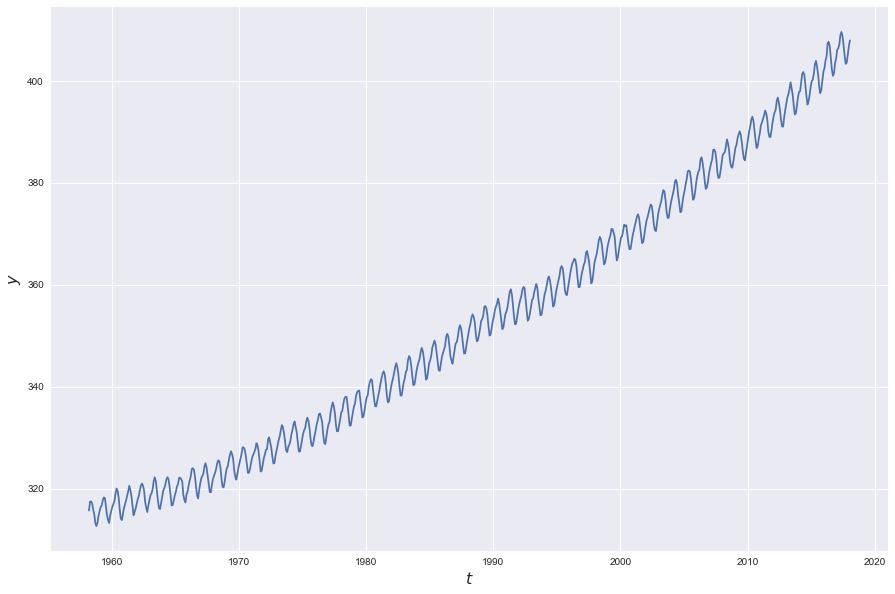

In [2]:
#load data 
data = np.loadtxt('mauna_loa_co2.txt')
t = data[:, 2][:, None]  #time (in decimal dates)
y = data[:, 4][:, None]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(t, y)
ax.set_xlabel('$t$', fontsize = 16)
ax.set_ylabel('$y$', fontsize = 16)

In [3]:
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class CustomBasis(object):
    """
    A custom set of basis functions to fit the 
    Mauna Loa data.
    """
    def __init__(self):
        self.num_basis = 5
        self.c = 0.04
    
    def __call__(self, x):
        x = x[0]
        return np.array([1, x, x**2, 
                         np.exp(self.c*x), np.sin(2*np.pi*x)])

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since the vast majority of the population inhabits the Northen hemisphere, fuel consumption goes up during the Northen winters. Our goal is to study this data set with the regression techniques we learned in class. Specifically we would like to provide an answer to the following task.
+ **Task 1** Predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 (ten years from now).
+ **Task 2**  Quantify our uncertainty about this prediction.

### Part  A 

Use any Bayesian linear regression technique discussed in class to construct a map between $t$ and $y$. State clearly which basis functions you use and why. We suggest you use automatic relevance determination (ARD) as implemented in [scikitlearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html).

The choice of the candidate basis functions is completely up to you. We expect you to justify your choices and interpret your findings. E.g., "I picked these basis functions because I expected this to happen", or "ARD finally selected these basis functions and this can be interpreted as this and that." 

### Solution

Consider the following basis:
$$
\phi(x) = [1,\ x,\ x^2,\ \exp(0.04x),\ \sin(2\pi x)]^T
$$

The first 4 terms are meant to capture the general trend and arbitrary fluctuations of the data. The sinusoidal basis function is meant to capture the seasonal variation. 

Now we set up the Bayesian linear regression model and use it to make predictions. 

In [4]:
#set up X and Y
X = t - np.min(t)   # Note the translation of the time input
Y = y

#set up ARD regression
phi = CustomBasis()
Phi = compute_design_matrix(X, phi)
reg = ARDRegression()
reg.fit(Phi, Y)

#get estimated values of the hyperparameters 
sigma2 = reg.alpha_
beta = 1./sigma2
alpha = reg.lambda_

#get posterior mean and covariance of the weights 
AN = beta*np.dot(Phi.T, Phi) + np.diag(alpha)  #post. precision
L = scipy.linalg.cho_factor(AN) #cholesky decomposition
SN = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1])) #post. covariance
mN = beta*np.dot(SN, np.dot(Phi.T, Y)) #post. mean

 /Users/rohitkt10/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


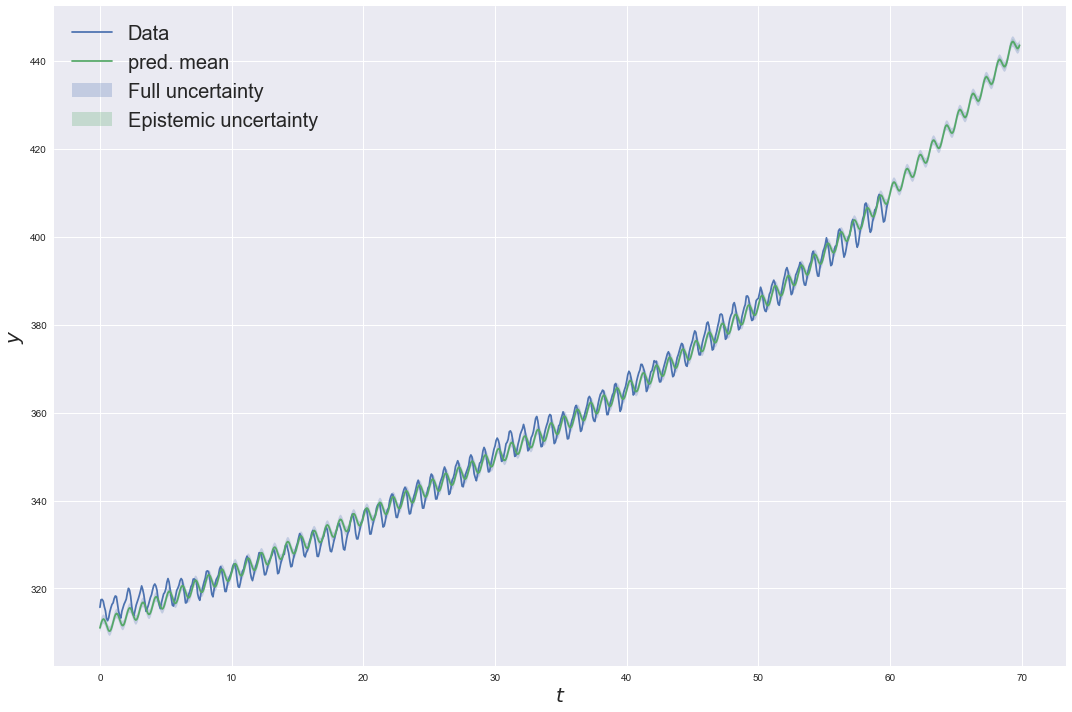

In [5]:
#post. predictive distribution 
xp = np.linspace(0, np.max(X) + 10, 1000)[:, None]
Phip = compute_design_matrix(xp, phi)
yp = np.dot(Phip, mN)   #posterior predictive mean 
vp = np.array([np.dot(phi(x)[:, None].T, np.dot(SN,phi(x)[:, None])) + sigma2 \
              for x in xp])[:, :, 0]
vep = vp - sigma2
stdp = np.sqrt(vp)[:, 0]
stdep = np.sqrt(vep)[:, 0]

#visualize 
plt.figure(figsize=(15, 10))
plt.plot(X, Y, label = 'Data')
plt.plot(xp, yp, label = 'pred. mean')
plt.fill_between(xp[:, 0], yp[:, 0] - 2*stdp, yp[:, 0] + 2*stdp, alpha = 0.25, 
                 label = 'Full uncertainty')
plt.fill_between(xp[:, 0], yp[:, 0] - 2*stdep, yp[:, 0] + 2*stdep, alpha = 0.25, 
                 label = 'Epistemic uncertainty')
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$y$', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
plt.tight_layout()

We seem to be capturing the general trend pretty nicely. The amplitude of the seasonal component, however, is not well captured. This can perhaps be fixed with a better choice of basis functions. 

#### Future CO$_2$ level projection

The projection of the CO$_2$ levels for the next 10 years is shown on the upper right hand side of the plot shown above.

#### Uncertainty about future predictions 

Text(0,0.5,u'$s(x)^2$')

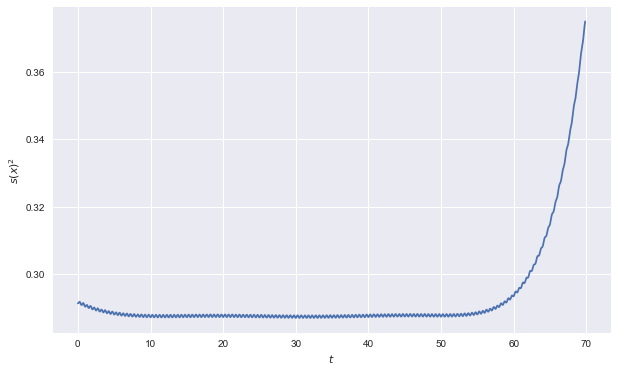

In [6]:
plt.figure(figsize = (10, 6))
plt.plot(xp, vp)
plt.xlabel('$t$')
plt.ylabel('$s(x)^2$')

The plot above shows the predictive variance over the time interval in which data is available and the predictive variance for future times. We note that beyond $t = 60$ (the point upto which we have data), the uncertainty of the forecast increases sharply.  

### Part B

In this problem you have to do exactly the same as in problem 1, but using Gaussian process regression using ``GPy``. 

The kernel selection is done exactly as shown in [section 5.4.3 of Rasmussen](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf).

In [7]:
import GPy 

In [8]:
#define kernels 
k1 = GPy.kern.RBF(1)
k21 = GPy.kern.StdPeriodic(1, period=1.) 
k22 = GPy.kern.RBF(1) #Sq.exponential
k2 = GPy.kern.Prod(kernels=[k21, k22]) #take product
k3 = GPy.kern.RatQuad(1)
k4=GPy.kern.RBF(1)
k = k1+k2+k3+k4

#####
## we will optimize once and save the model. If there is a saved model we 
## will just load the saved model because optimization takes time. 

#load saved model or define, optimize and save GP model
if os.path.exists('mauna_loa_gpmodel.pkl'):
    m = pickle.load(open('mauna_loa_gpmodel.pkl', 'rb'))
else:
    m=GPy.models.GPRegression(X, Y, k)
    m.optimize_restarts(10) 
    pickle.dump(m, open('mauna_loa_gpmodel.pkl', 'wb'))

In [9]:
#print out the model and check hyperparameter values 
print m


Name : GP regression
Objective : 246.654945593
Number of Parameters : 13
Number of Optimization Parameters : 13
Updates : True
Parameters:
  GP_regression.                    |                    value  |  constraints  |  priors
  sum.rbf.variance                  |       0.4005076161212404  |      +ve      |        
  sum.rbf.lengthscale               |       0.7507364260238721  |      +ve      |        
  sum.mul.std_periodic.variance     |       301.23219145004975  |      +ve      |        
  sum.mul.std_periodic.period       |       0.9999672637895662  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |        6.218574715003326  |      +ve      |        
  sum.mul.rbf.variance              |        358.9455530369782  |      +ve      |        
  sum.mul.rbf.lengthscale           |        205.0708343112237  |      +ve      |        
  sum.RatQuad.variance              |       1195.8820155131302  |      +ve      |        
  sum.RatQuad.lengthscale           |        34.05

In [10]:
#make predictions and compute the full and epistemic uncertainty 
yp, vp = m.predict(xp)
sigma2 = m.Gaussian_noise.variance.values[0]
vep = vp - sigma2
stdp = np.sqrt(vp)[:, 0]
stdep = np.sqrt(vep)[:, 0]

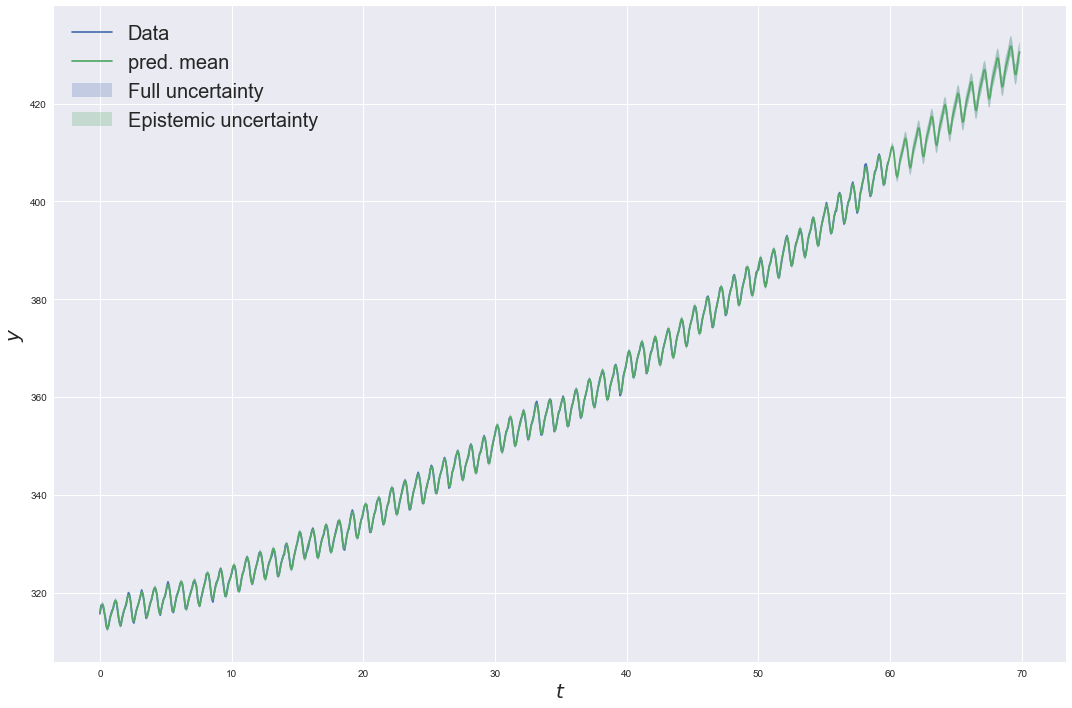

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(X, Y, label = 'Data')
plt.plot(xp, yp, label = 'pred. mean')
plt.fill_between(xp[:, 0], yp[:, 0] - 2*stdp, yp[:, 0] + 2*stdp, alpha = 0.25, 
                 label = 'Full uncertainty')
plt.fill_between(xp[:, 0], yp[:, 0] - 2*stdep, yp[:, 0] + 2*stdep, alpha = 0.25, 
                 label = 'Epistemic uncertainty')
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$y$', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
plt.tight_layout()

Notice the (slowly) growing error bars in the forecast region.

## Problem 2 - Stochastic model for permeability of oil reservoir

The permeability of the soil is one of the largest unknowns in modeling underground flows. Here, you will create a 2D model of permeability that can be used for propagating uncertainties or as a starting point for model calibration. This is the information that is available to you:
+ You need to build a stochastic model for permeability with as low dimensionality as possible.
+ You need to be able to sample random permeability fields from this model.
+ The permeability is strictly positive.
+ The 2D domain you should consider is $[0, 356]\times[0,670]$ (in meters).
+ Our geologist gave us her best estimate about the permeability field. We have put the results for you in a data file and we show you how to load it and plot it below.
+ When asked how sure she is about the prediction, the geologist gave a standard deviation of about 3.2 on the logarithm of the permeability.
+ She also believes that there are two lengthscales: 50 meters and 10 meters.

Do the following:

a. Write down the mathematical form of the best stochastic model for the permeability you can come up with using the information above. Are you going to use a GP? Are you going to consider a transformed version of the GP? What would the mean be? What would the covariance function be? What would the parameters of the covariance function be?

b. Construct the Karhunen-Loeve expansion of the field using the code provided in lecture 12. You should: 1) use enough quadrature points so that you get a converged Nystrom approximation; 2) use enough terms to cover $95\%$ of the fields energy; 3) Plot the egenvalues of KLE; 4) Plot the first six eigenfunctions of KLE; 5) Plot six samples of the random field.

c. You sent a crew to go and make some measurements of the permeability. Repeate everything you did in b. making use of the new data:
 

|$x_1$ |$x_2$ | $\log K(x_1, x_2)$ |
|------|------|--------------------|
|100.  |200.  | -13.2              |
|300.  |500.  | -25.3              |
 
Here is the mean field provided by the geologist:

Text(0.5,1,u'Mean of the log permeability')

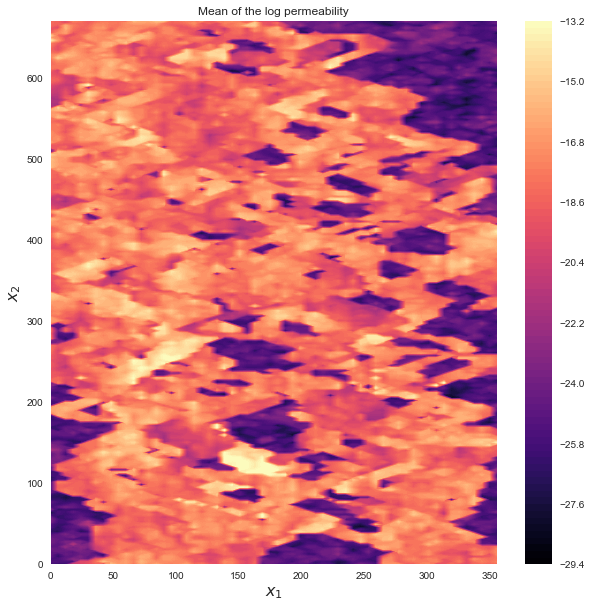

In [12]:
M = np.loadtxt('spe10_permx.dat').T
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)
fig, ax = plt.subplots(1, figsize = (10, 10))
im=ax.contourf(X1, X2, np.log(M), 100, cmap = 'magma')
fig.colorbar(im, ax=ax)
ax.set_xlabel('$x_1$', fontsize = 16)
ax.set_ylabel('$x_2$', fontsize = 16)
ax.set_title('Mean of the log permeability')

In [13]:
class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum("i,ji,j,rj->ri", 1. / self.lam, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

### Solution 
#### Part a

We will represent the logarithm of the permeability field as the following Gaussian process:
$$
\log K(\mathbf{x}) = \mathrm{GP}(\log K|m(\cdot), k(\cdot, \cdot)),
$$
where, $\mathbf{x} = (x_1, x_2)$, the mean function $m$ is such that the discretized version of the mean is the log of the data given in the ```spe10_permx.dat``` file, and the covariance function $k$ is an Exponential covariance kernel with lengthscales, $\ell_x = 50\mathrm{m}$ and $\ell_y = 10\mathrm{m}$. For the purpose of computation we will scale the permeability field to the unit square, $[0, 1]^2$. The modified lengthscales will be $\ell = (50/356, 10/670)$. Per the recommendation of the geologist we will set the signal strength of the kernel to $3.2^2$.

In [14]:
#define the kernel 
k = GPy.kern.Exponential(2, 
                         lengthscale=[50./356, 10./670], 
                         variance = 3.2**2,
                         ARD=True)

The truncated KLE of the log permeability field is as follows:
$$
\log K = m(\cdot) + \sum_{i=1}^{d} \sqrt{\lambda_i} \phi_i(\cdot) \xi_i,
$$
where $d$ is the number of terms retained in the KL representation, $\xi_i$ are uncorrelated standard normal RVs, and $(\phi_i, \lambda_i)$ are the eigenpairs of the covariance function.

#### Part b

In [15]:
#get the KLE
nq = 1000 #num of quadrature points 
alpha = 0.95 #energy of the field to retain
kle = KarhunenLoeveExpansion(k, nq=1000, alpha=alpha)

Text(0,0.5,u'$\\lambda_i$')

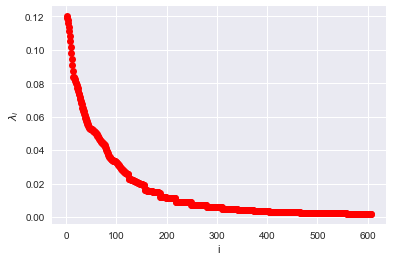

In [16]:
#plot the eigenvalues of the cov. function
numxi = kle.num_xi
plt.plot(np.arange(1,numxi+1), kle.lam, 'ro')
plt.xlabel('i')
plt.ylabel('$\lambda_i$')

In [17]:
#create a grid in the unit square ; 
#scale it back to the original dimensions later 
x1 = np.linspace(0, 1, 60)
x2 = np.linspace(0, 1, 220)
X1, X2 = np.meshgrid(x1, x2)
Xgrid = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])

In [18]:
#get eigenfunction evaluations at grid points 
Phi = kle.eval_phi(Xgrid)

In [19]:
#get first 6 eigenfunctions  
Phi6 = Phi[:, :6]

#reshape
Phi6 = Phi6.reshape((220, 60, 6))

In [20]:
#get 6 samples 
samples = []
for i in xrange(6):
    xi = np.random.randn(kle.num_xi)
    sample = kle.tmp_mu + np.dot(Phi, xi * kle.sqrt_lam)  #save time recomputing Phi
    sample = sample.reshape((220, 60)) + M
    samples.append(np.exp(sample))
samples = np.array(samples)

In [21]:
#rescale grid 
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)

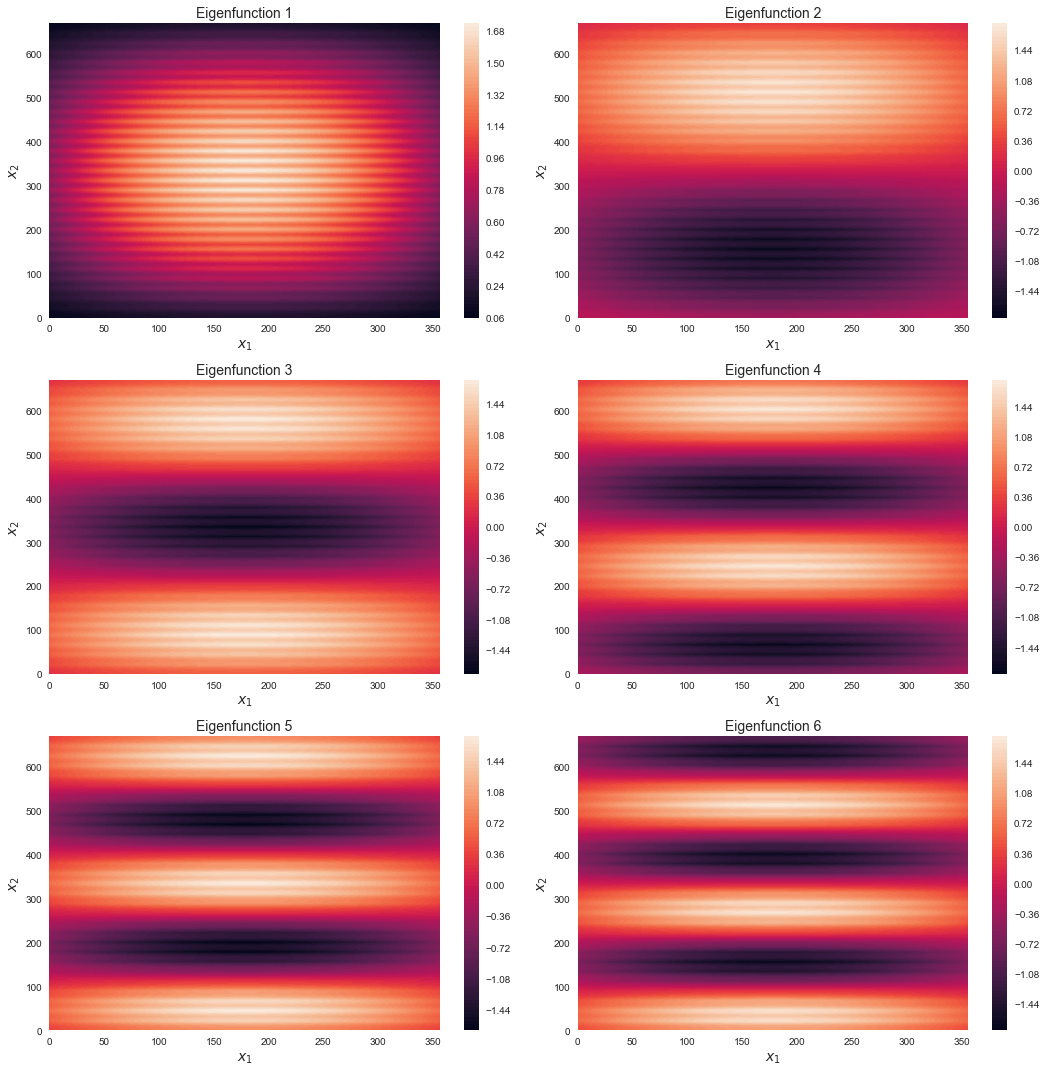

In [22]:
#plot the first six eigenfunction
fig, ax = plt.subplots(3, 2, figsize = (15, 15))
for i in xrange(3):
    for j in xrange(2):
        im = ax[i, j].contourf(X1, X2, Phi6[:, :, i*2 + j], 100)
        ax[i, j].set_xlabel('$x_1$', fontsize = 14)
        ax[i, j].set_ylabel('$x_2$', fontsize = 14)
        ax[i, j].set_title('Eigenfunction '+str(2*i + j + 1), fontsize = 14)
        fig.colorbar(im, ax = ax[i, j])
fig.tight_layout()

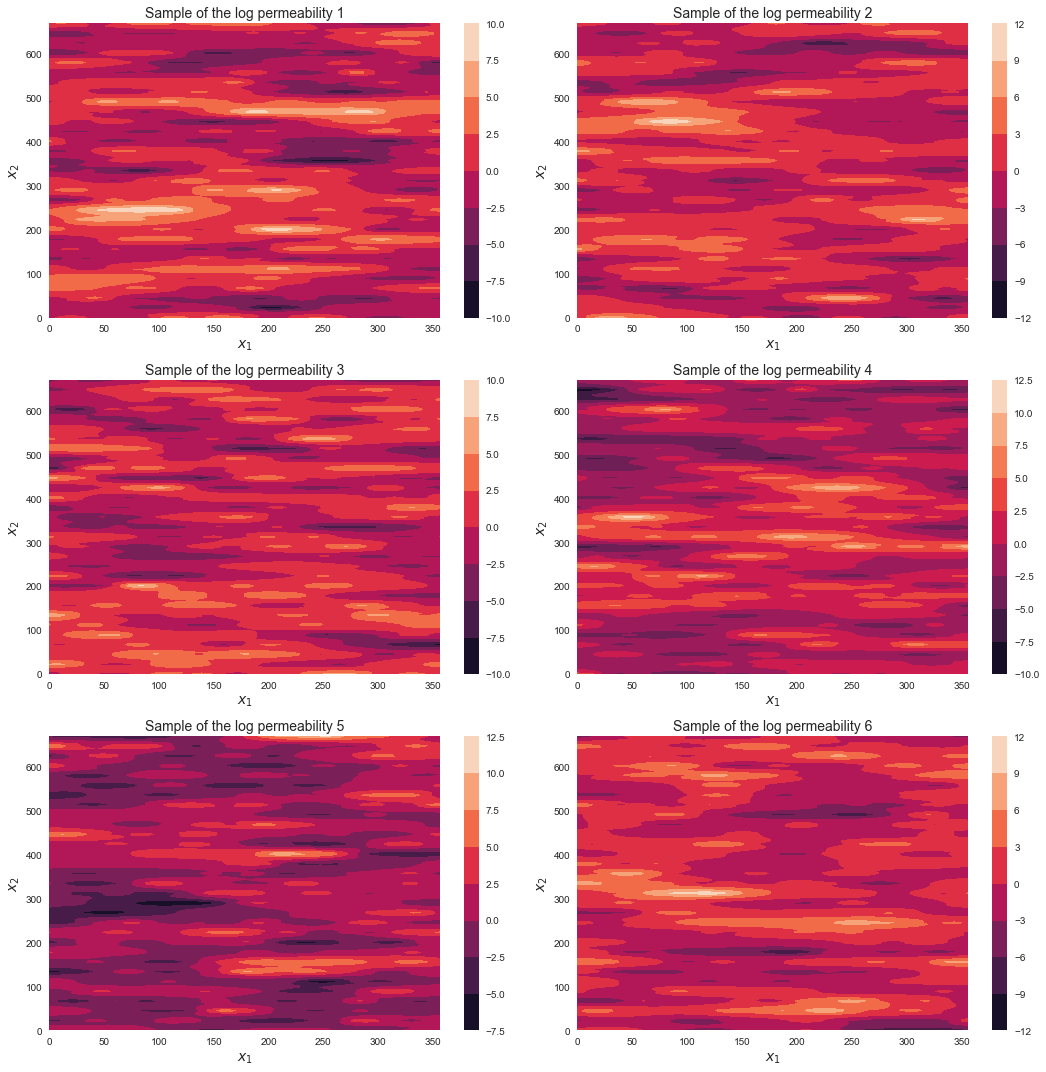

In [23]:
#plot six samples
fig, ax = plt.subplots(3, 2, figsize = (15, 15))
for i in xrange(3):
    for j in xrange(2):
        im = ax[i, j].contourf(X1, X2, np.log(samples[i*2 + j]))
        ax[i, j].set_xlabel('$x_1$', fontsize = 14)
        ax[i, j].set_ylabel('$x_2$', fontsize = 14)
        ax[i, j].set_title('Sample of the log permeability '+str(2*i + j + 1), fontsize = 14)
        fig.colorbar(im, ax = ax[i, j])
fig.tight_layout()

#### Part c

In [24]:
#field measurements
Xp = np.array([[100./356, 200./670], [300./356, 500./670]])  #observed locations 
Yp = np.array([[-13.2], [-25.3]])  #observed log permeability
#get the KLE
nq = 1000 #num of quadrature points 
alpha = 0.95 #energy of the field to retain
kle = KarhunenLoeveExpansion(k, nq=1000, alpha=alpha, X=Xp, Y=Yp[:, 0])

Text(0.5,1,u'$d = $608')

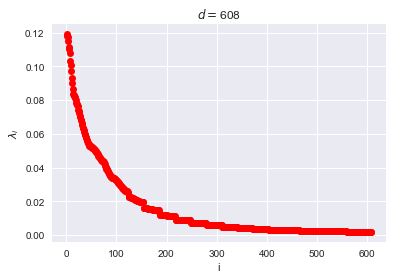

In [25]:
#plot the eigenvalues of the cov. function
numxi = kle.num_xi
plt.plot(np.arange(1,numxi+1), kle.lam, 'ro')
plt.xlabel('i')
plt.ylabel('$\lambda_i$')
plt.title('$d = $'+str(numxi))

In [26]:
#create a grid in the unit square ; 
#scale it back to the original dimensions later 
x1 = np.linspace(0, 1, 60)
x2 = np.linspace(0, 1, 220)
X1, X2 = np.meshgrid(x1, x2)
Xgrid = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])

In [27]:
#get eigenfunction evaluations at grid points 
Phi = kle.eval_phi(Xgrid)

In [28]:
#get first 6 eigenfunctions  
Phi6 = Phi[:, :6]

#reshape
Phi6 = Phi6.reshape((220, 60, 6))

In [29]:
#get 6 samples 
samples = []
for i in xrange(6):
    xi = np.random.randn(kle.num_xi)
    sample = kle.tmp_mu + np.dot(Phi, xi * kle.sqrt_lam)  #save time recomputing Phi
    sample = sample.reshape((220, 60)) + M
    samples.append(np.exp(sample))
samples = np.array(samples)

In [30]:
#rescale grid 
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)

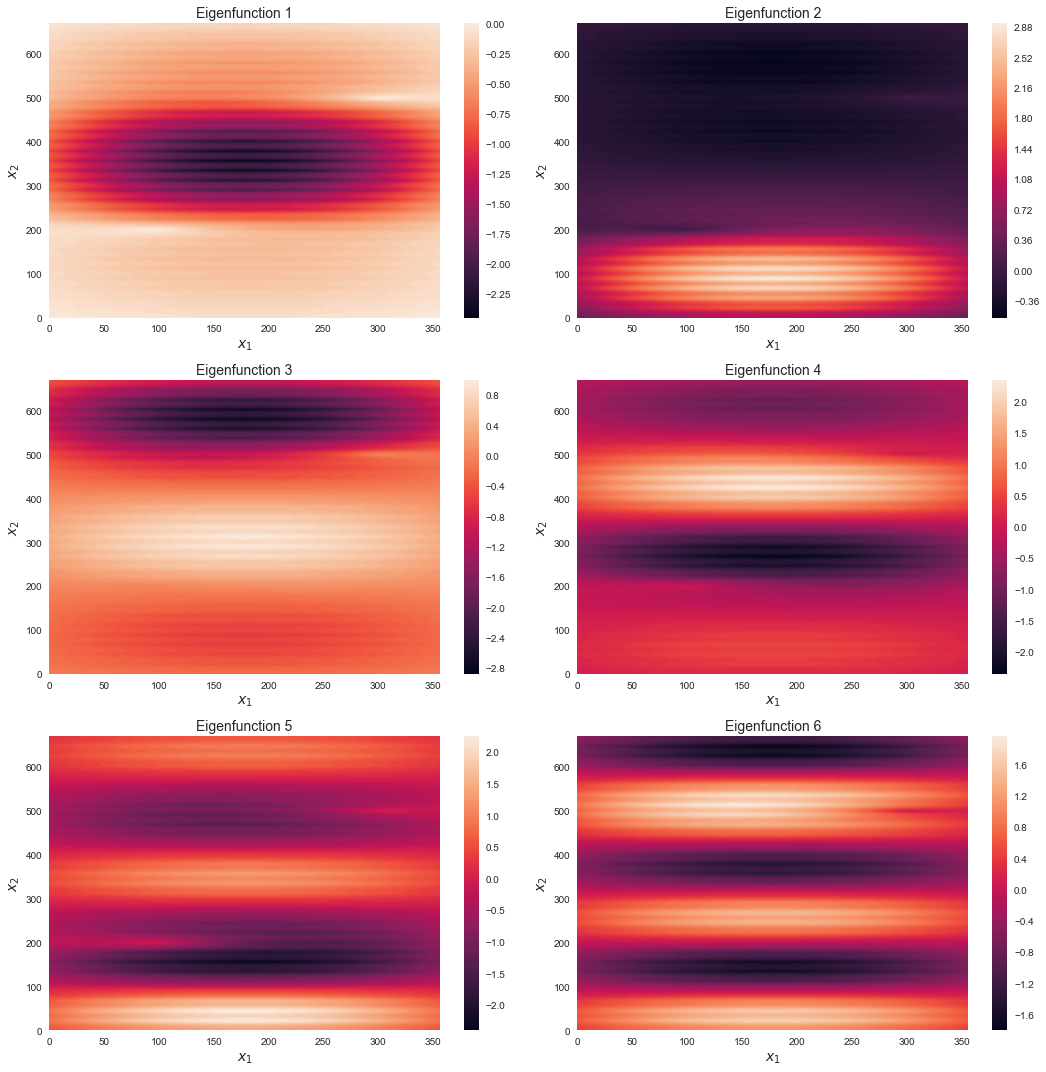

In [31]:
#plot the first six eigenfunction
fig, ax = plt.subplots(3, 2, figsize = (15, 15))
for i in xrange(3):
    for j in xrange(2):
        im = ax[i, j].contourf(X1, X2, Phi6[:, :, i*2 + j], 100)
        ax[i, j].set_xlabel('$x_1$', fontsize = 14)
        ax[i, j].set_ylabel('$x_2$', fontsize = 14)
        ax[i, j].set_title('Eigenfunction '+str(2*i + j + 1), fontsize = 14)
        fig.colorbar(im, ax = ax[i, j])
fig.tight_layout()

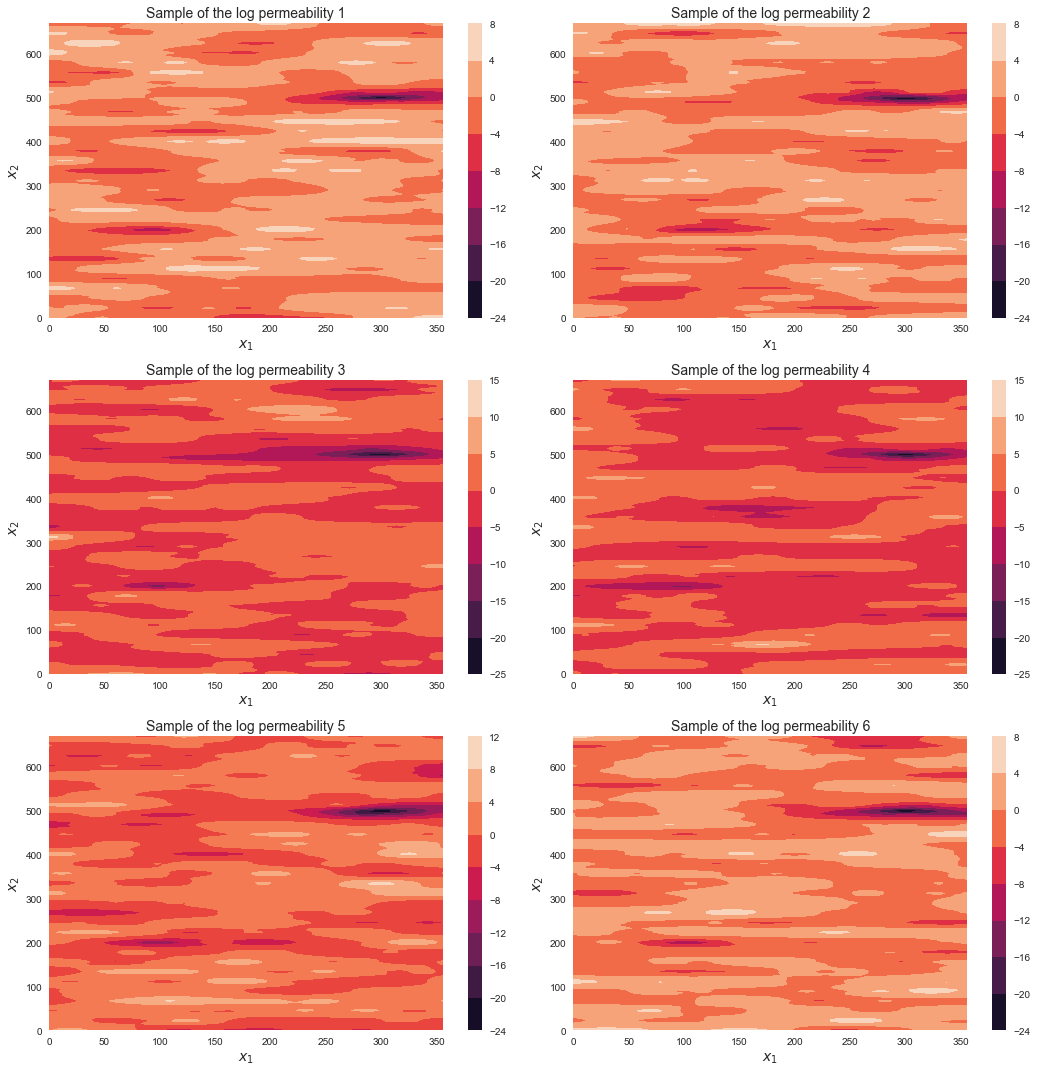

In [32]:
#plot six samples
fig, ax = plt.subplots(3, 2, figsize = (15, 15))
for i in xrange(3):
    for j in xrange(2):
        im = ax[i, j].contourf(X1, X2, np.log(samples[i*2 + j]))
        ax[i, j].set_xlabel('$x_1$', fontsize = 14)
        ax[i, j].set_ylabel('$x_2$', fontsize = 14)
        ax[i, j].set_title('Sample of the log permeability '+str(2*i + j + 1), fontsize = 14)
        fig.colorbar(im, ax = ax[i, j])
fig.tight_layout()